In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])
train_set = datasets.CIFAR10(root='data/', download=True, transform=transform, train=True)
train_set, validation_set = torch.utils.data.random_split(train_set,[42000,8000])
test_set = datasets.CIFAR10(root='data/', download=True, transform=transform, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [3]:
inception_v3 = torchvision.models.inception_v3(pretrained=True)
inception_v3.fc = nn.Linear(2048, 10).to(torch.device('cuda'))
inception_v3.AuxLogits.fc = nn.Linear(768, 10).to(torch.device('cuda'))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [4]:
for parameter in inception_v3.parameters():
  parameter.requires_grad = False
for parameter in inception_v3.fc.parameters():
  parameter.requires_grad = True
for parameter in inception_v3.AuxLogits.fc.parameters():
  parameter.requires_grad = True

for name, module in inception_v3.named_modules():
  if isinstance(module, nn.BatchNorm2d):
    module.track_running_stats = False

In [5]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, inception_v3.parameters()))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception_v3.to(device)

batch_size = 40
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)

In [7]:
num_epochs = 10
num_iters_train = len(train_loader)
num_iters_validation = len(validation_loader)

train_losses = np.zeros((num_epochs, num_iters_train))
validation_losses = np.zeros((num_epochs, num_iters_validation))

train_acc_list = []
validation_acc_list = []

for epoch in range(num_epochs):
  train_acc = 0
  validation_acc = 0

  criterion = nn.CrossEntropyLoss()
  for it, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)
    outputs = inception_v3(X)

    loss = criterion(outputs[0], y) + criterion(outputs[1], y)
    train_losses[epoch, it] = loss
    train_acc += int(torch.sum(y == torch.argmax(outputs[0], dim=1)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_acc = train_acc / len(train_set) * 100
  train_acc_list.append(train_acc)  
  print('Training epoch number', epoch + 1, '-->   Loss :', train_losses[epoch].sum() / len(train_loader), ' | Accuracy :', train_acc)

  criterion = nn.CrossEntropyLoss()
  for it, (X, y) in enumerate(validation_loader):
    X, y = X.to(device), y.to(device)
    outputs = inception_v3(X)

    loss = criterion(outputs[0], y)
    validation_losses[epoch, it] = loss
    validation_acc += int(torch.sum(y == torch.argmax(outputs[0], dim=1)))

  validation_acc = validation_acc / len(validation_set) * 100
  validation_acc_list.append(validation_acc)

  if np.argmax(validation_acc_list) == epoch:
    torch.save(inception_v3, 'inception_cifar10_classifier.pth')

  print('Validation epoch number', epoch + 1, '-->   Loss :', validation_losses[epoch].sum() / len(validation_loader), ' | Accuracy :', validation_acc)

Training epoch number 1 -->   Loss : 1.858362323953992  | Accuracy : 65.32619047619048
Validation epoch number 1 -->   Loss : 0.8957042795419693  | Accuracy : 68.83749999999999
Training epoch number 2 -->   Loss : 1.570636177857717  | Accuracy : 69.38095238095238
Validation epoch number 2 -->   Loss : 0.8982032170891762  | Accuracy : 68.9125
Training epoch number 3 -->   Loss : 1.5285846680686588  | Accuracy : 70.14285714285714
Validation epoch number 3 -->   Loss : 0.8768708916008472  | Accuracy : 70.5125
Training epoch number 4 -->   Loss : 1.5339124883356547  | Accuracy : 69.46190476190476
Validation epoch number 4 -->   Loss : 0.8902977672219277  | Accuracy : 70.3125
Training epoch number 5 -->   Loss : 1.4926896286578406  | Accuracy : 70.2952380952381
Validation epoch number 5 -->   Loss : 0.9044285024702549  | Accuracy : 69.4375
Training epoch number 6 -->   Loss : 1.5047282272861118  | Accuracy : 69.83095238095238
Validation epoch number 6 -->   Loss : 0.9231706024706363  | Accu

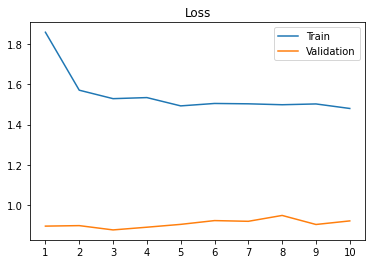

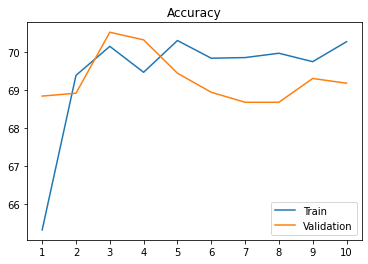

In [8]:
x_label = np.arange(1, num_epochs + 1)
y_training_loss = np.sum(train_losses, axis=1) / len(train_loader)
y_validation_loss = np.sum(validation_losses, axis=1) / len(validation_loader)
y_training_acc = np.array(train_acc_list)
y_validation_acc = np.array(validation_acc_list)


plt.plot(x_label, y_training_loss)
plt.plot(x_label, y_validation_loss)
plt.xticks(x_label)
plt.title("Loss")
plt.legend(['Train', 'Validation'])
plt.figure()

plt.plot(x_label, y_training_acc)
plt.plot(x_label, y_validation_acc)
plt.xticks(x_label)
plt.title("Accuracy")
plt.legend(['Train', 'Validation'])
plt.show()

In [44]:
classifier = torch.load('inception_cifar10_classifier.pth')

with torch.no_grad():
    test_acc = 0
    missclassified_images = []
    counter = 0
    confusion_matrix = np.zeros((10, 10))

    for it, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        outputs = classifier(X)

        outputs[0].to(torch.device('cpu'))
        test_acc += int(torch.sum(y == torch.argmax(outputs[0], dim=1)))
        for i in range(len(y)):
          confusion_matrix[y[i], torch.argmax(outputs[0][i])] += 1

        miss_indices = []
        if counter < 20:
          for i in range(len(y)):
            if y[i] != torch.argmax(outputs[0][i]):
              miss_indices.append(i)
          if len(miss_indices) != 0:
            for num in miss_indices:
              counter += 1
              missclassified_images.append((X[num], int(y[num]), int(torch.argmax(outputs[0][num]))))
      
    test_acc = test_acc / len(test_set) * 100
    print('Accuracy on test set :', test_acc)

Accuracy on test set : 70.07


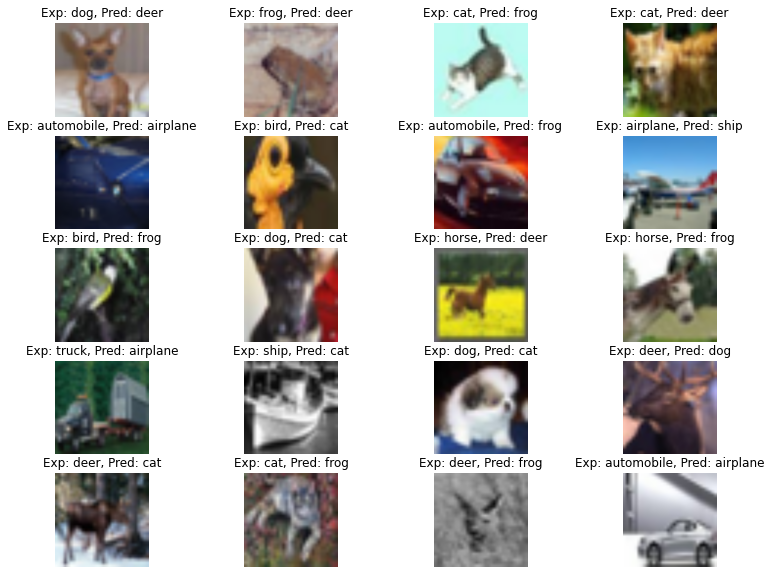

In [45]:
fig = plt.figure(figsize=(13, 10))
label_objects = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
for i in range(20):
  fig.add_subplot(5, 4, i + 1)
  plt.title('Exp: {0}, Pred: {1}'.format(label_objects[missclassified_images[i][1]], label_objects[missclassified_images[i][2]]))
  plt.axis('off')
  plt.imshow(transforms.ToPILImage()(missclassified_images[i][0]))

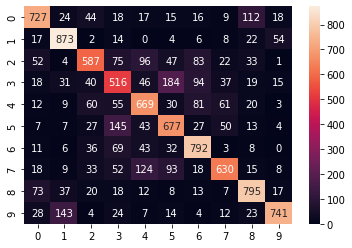

In [46]:
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, fmt='g')
plt.show()